In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib notebook

from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

/home/amit/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Load the spam data
data = pd.read_csv('../data/prostate.data',sep='\t',index_col=0)
data = data.sample(frac=1).reset_index(drop=True)


X_cols = [col for col in data.columns if (col not in ['train','lpsa'])]
y_cols = ['lpsa']

# Scale the columns to mean 0 and var 
scaler = StandardScaler()
data[X_cols] = scaler.fit_transform(data[X_cols])

### Split into training and test data

In [3]:
# # # Split in train/test
train_data = data[data.train=='T']
test_data = data[data.train=='F']

train_data = train_data.drop(['train'],axis=1)
test_data = test_data.drop(['train'],axis=1)

### Training data correlation matix (Table 3.1 on page 50)

In [4]:
train_data[X_cols].corr()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.000000,0.300232,0.286324,0.063168,0.592949,0.692043,0.426414,0.483161
lweight,0.300232,1.000000,0.316723,0.437042,0.181054,0.156829,0.023558,0.074166
age,0.286324,0.316723,1.000000,0.287346,0.128902,0.172951,0.365915,0.275806
lbph,0.063168,0.437042,0.287346,1.000000,-0.139147,-0.088535,0.032992,-0.030404
svi,0.592949,0.181054,0.128902,-0.139147,1.000000,0.671240,0.306875,0.481358
lcp,0.692043,0.156829,0.172951,-0.088535,0.671240,1.000000,0.476437,0.662533
gleason,0.426414,0.023558,0.365915,0.032992,0.306875,0.476437,1.000000,0.757056
pgg45,0.483161,0.074166,0.275806,-0.030404,0.481358,0.662533,0.757056,1.000000


### Fitting a linear regression (Table 3.2 page 50)

In [61]:
X_train = train_data[X_cols].values
y_train = train_data[y_cols].values
X_test = test_data[X_cols].values
y_test = test_data[y_cols].values

In [6]:
# Linear regression OLS
X_train_ols = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_ols)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     16.47
Date:                Mon, 25 Mar 2019   Prob (F-statistic):           2.04e-12
Time:                        21:02:15   Log-Likelihood:                -67.505
No. Observations:                  67   AIC:                             153.0
Df Residuals:                      58   BIC:                             172.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4649      0.089     27.598      0.0

### Best subset selection through exhaustive search $2^{nfeatures}$

In [7]:
def fit_linear_reg(X,y,fit_intercept=True):
    #Fit linear regression model and return mse and R squared values
    model_k = LinearRegression(fit_intercept)
    model_k.fit(X,y)
    MSE = mean_squared_error(y,model_k.predict(X)) * len(y)
    R_squared = model_k.score(X,y)
    return MSE, R_squared

def fit_stat_linear_reg(X,y):
    X_train_ols = sm.add_constant(X)
    model = sm.OLS(y, X_train_ols)
    results = model.fit()
    return results

In [8]:
import itertools

n_features = len(X_cols)
total_combinations = 2**n_features

results_df = pd.DataFrame(columns=['features','mse','r2','n_features'])
stuff = np.arange(n_features)

rownum = 0
for L in range(0, len(stuff)+1):
    for subset in itertools.combinations(stuff, L):
        if len(subset)>0:
            mse,r2 = fit_linear_reg(X_train[:,subset],y_train)
            results_df.loc[rownum] = [subset, mse, r2, len(subset)]
            rownum = rownum + 1
        else: # Just fit the intercept for 0 size
            mse,r2 = fit_linear_reg(np.ones(y_train.shape),y_train,fit_intercept=False)
            results_df.loc[rownum] = [subset, mse, r2, len(subset)]
            rownum = rownum + 1

### Figure 3.5 (page 58): Plot all RSS for all models and select the best for each subset size

<IPython.core.display.Javascript object>


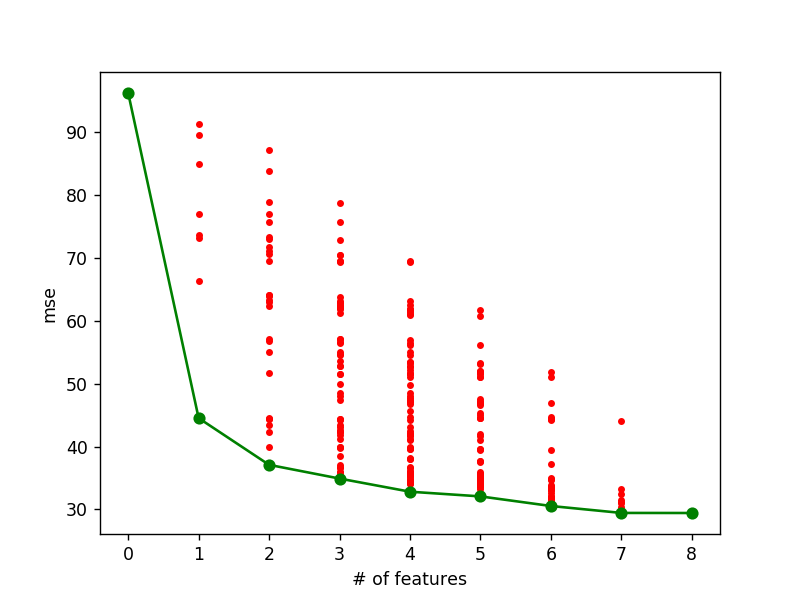

Text(0,0.5,'mse')

In [9]:
best_mse = results_df.groupby('n_features')['mse'].min()
fig,ax = plt.subplots()
ax.plot(results_df.n_features,results_df.mse,'r.')
ax.plot(best_mse.index,best_mse.values,'go-')
ax.set_xlabel('# of features')
ax.set_ylabel('mse')

## Now choose the best models among these using cross validation

In [10]:
best_models = results_df[results_df.groupby('n_features')['mse'].transform(min)==results_df['mse']]

In [11]:
best_models

,features,mse,r2,n_features
0,(),96.281445,1.110223e-16,0
1,"(0,)",44.528583,5.375165e-01,1
9,"(0, 1)",37.091846,6.147560e-01,2
39,"(0, 1, 4)",34.907749,6.374405e-01,3
98,"(0, 1, 3, 4)",32.814995,6.591763e-01,4
175,"(0, 1, 3, 4, 7)",32.069447,6.669198e-01,5
230,"(0, 1, 3, 4, 5, 7)",30.539778,6.828072e-01,6
248,"(0, 1, 2, 3, 4, 5, 7)",29.437300,6.942578e-01,7
255,"(0, 1, 2, 3, 4, 5, 6, 7)",29.426384,6.943712e-01,8


### 5-fold cross-validation

/home/amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


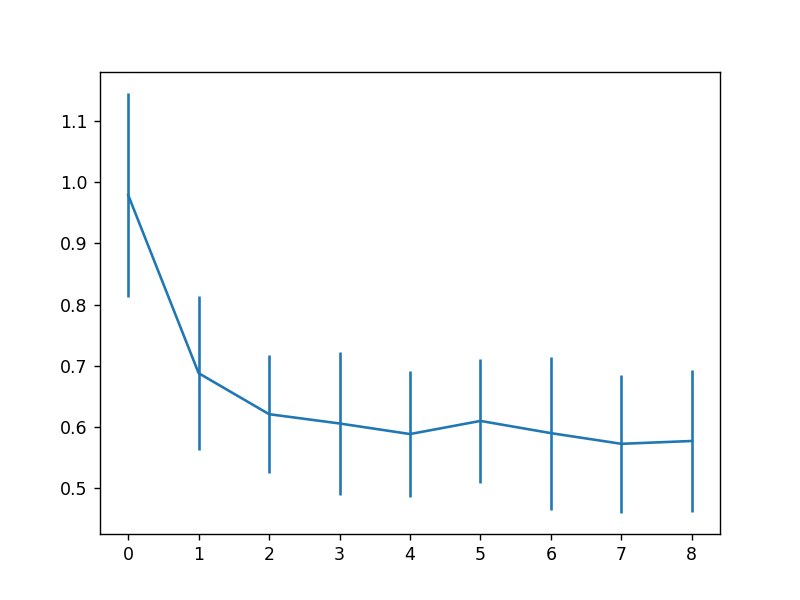

<ErrorbarContainer object of 3 artists>

In [12]:
from sklearn.model_selection import cross_val_score

mean_CV_error = {}
std_CV_error = {}

for ind in range(best_models.shape[0]):
    model = LinearRegression(fit_intercept=True)
    row = best_models.iloc[ind]
    if row.n_features>0:
        scores = cross_val_score(model, X_train[:,row.features], y_train, cv=5, scoring='neg_mean_absolute_error')
    else:
        scores = cross_val_score(model, np.ones(y_train.shape), y_train, cv=5, scoring='neg_mean_absolute_error')
    
    mean_CV_error[row.n_features] = -np.mean(scores)
    std_CV_error[row.n_features] = np.std(scores)

# Append to the data frame
best_models['mean_CV_error_5fold'] = best_models['n_features'].map(mean_CV_error)
best_models['std_CV_error_5fold'] = best_models['n_features'].map(std_CV_error)

fig,ax = plt.subplots()
ax.errorbar(best_models.n_features,best_models.mean_CV_error_5fold,best_models.std_CV_error_5fold)


In [45]:
mean_CV_values = best_models.mean_CV_error_5fold.values
std_CV_values = best_models.std_CV_error_5fold.values
min_ind = np.argmin(mean_CV_values)
CV_mean_threshold = mean_CV_values[min_ind] + std_CV_values[min_ind]
chosen_model_ind = np.nonzero(mean_CV_values < CV_mean_threshold)

In [58]:
best_models[best_models.mean_CV_error_5fold.values==mean_CV_values[np.min(chosen_model_ind[0])]]

,features,mse,r2,n_features,mean_CV_error_5fold,std_CV_error_5fold,mean_CV_error_10fold,std_CV_error_10fold
9,"(0, 1)",37.091846,0.614756,2,0.620561,0.096437,0.613994,0.223823


In [57]:
np.min(chosen_model_ind[0])

2

### 10-fold cross-validation

/home/amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


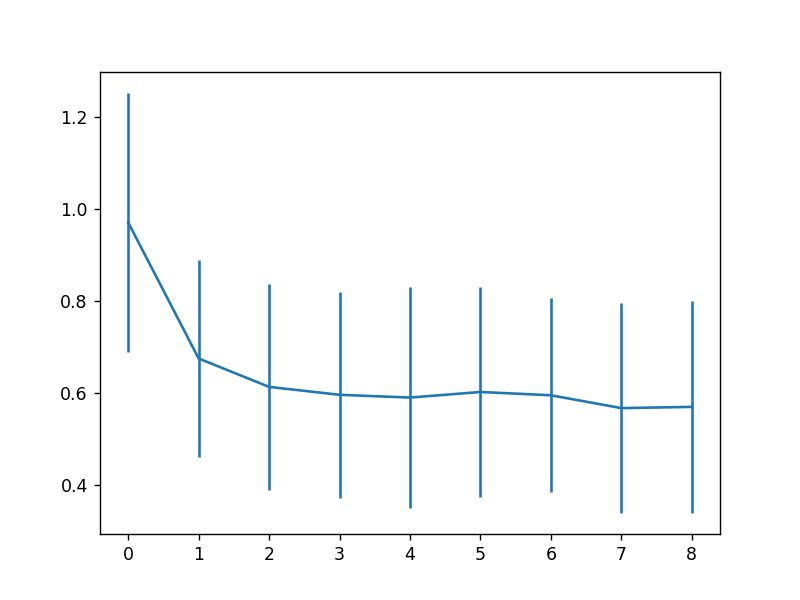

<ErrorbarContainer object of 3 artists>

In [13]:
from sklearn.model_selection import cross_val_score

mean_CV_error = {}
std_CV_error = {}

for ind in range(best_models.shape[0]):
    model = LinearRegression(fit_intercept=True)
    row = best_models.iloc[ind]
    if row.n_features>0:
        scores = cross_val_score(model, X_train[:,row.features], y_train, cv=10, scoring='neg_mean_absolute_error')
    else:
        scores = cross_val_score(model, np.ones(y_train.shape), y_train, cv=10, scoring='neg_mean_absolute_error')
    
    mean_CV_error[row.n_features] = -np.mean(scores)
    std_CV_error[row.n_features] = np.std(scores)

# Append to the data frame
best_models['mean_CV_error_10fold'] = best_models['n_features'].map(mean_CV_error)
best_models['std_CV_error_10fold'] = best_models['n_features'].map(std_CV_error)

fig,ax = plt.subplots()
ax.errorbar(best_models.n_features,best_models.mean_CV_error_10fold,best_models.std_CV_error_10fold)

In [14]:
best_models

,features,mse,r2,n_features,mean_CV_error_5fold,std_CV_error_5fold,mean_CV_error_10fold,std_CV_error_10fold
0,(),96.281445,1.110223e-16,0,0.979103,0.166918,0.971312,0.281250
1,"(0,)",44.528583,5.375165e-01,1,0.687629,0.125524,0.675722,0.213417
9,"(0, 1)",37.091846,6.147560e-01,2,0.620561,0.096437,0.613994,0.223823
39,"(0, 1, 4)",34.907749,6.374405e-01,3,0.605356,0.117215,0.596829,0.223654
98,"(0, 1, 3, 4)",32.814995,6.591763e-01,4,0.588056,0.103293,0.590818,0.239780
175,"(0, 1, 3, 4, 7)",32.069447,6.669198e-01,5,0.609539,0.101153,0.602958,0.227700
230,"(0, 1, 3, 4, 5, 7)",30.539778,6.828072e-01,6,0.589550,0.124989,0.595811,0.210537
248,"(0, 1, 2, 3, 4, 5, 7)",29.437300,6.942578e-01,7,0.572082,0.113188,0.567893,0.227889
255,"(0, 1, 2, 3, 4, 5, 6, 7)",29.426384,6.943712e-01,8,0.576714,0.115725,0.570619,0.230546


### Table 3.3

In [66]:
# Linear regression

model = LinearRegression(fit_intercept=True)
model.fit(X_train[:,[0,1]],y_train)

y_pred = np.array(model.predict(X_test[:,[0,1]]))
# The mean squared error
print("Mean squared error: %.3f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.3f' % r2_score(y_test, y_pred))

Mean squared error: 0.492
Variance score: 0.531
